# CNN-Based Rotation Correction - Advanced Machine Learning Project

### Matteo Breganni 869549

# Imports

In [115]:
from google.colab import drive
import zipfile
import shutil
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math

import random as random
import tensorflow as tf
from tensorflow import keras

np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
cv2.setRNGSeed(0)

# Dataset creation and split

In [151]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/drive')
shutil.copy('/content/drive/My Drive/landscape.zip', 'landscape.zip')
zipf = zipfile.ZipFile('landscape.zip')
zipf.extractall()
zipf.close()

os.remove('landscape.zip') # Delete the copied zip file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [150]:
#shutil.rmtree("dataset")

The images in the extracted folder are split between train, val and test sets with a 60-20-20 split and moved in their respective folders.

In [152]:
extracted_folder = "landscape"
dataset_folder = "dataset"
train_folder = os.path.join(dataset_folder, "train")
val_folder = os.path.join(dataset_folder, "val")
test_folder = os.path.join(dataset_folder, "test")

if(not os.path.exists(dataset_folder)):
    os.makedirs(dataset_folder)
    os.makedirs(train_folder)
    os.makedirs(val_folder)
    os.makedirs(test_folder)

    # Get all image files in the extracted_folder
    all_images = sorted([f for f in os.listdir(extracted_folder) if os.path.isfile(os.path.join(extracted_folder, f))])
    random.shuffle(all_images)  # Shuffle to ensure randomness

    # Calculate split sizes for 60-20-20
    total_images = len(all_images)
    train_count = int(total_images * 0.6)
    val_count = int(total_images * 0.2)

    # Split and move images
    train_images = all_images[:train_count]
    val_images = all_images[train_count:train_count + val_count]
    test_images = all_images[train_count + val_count:]
    for img in train_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(train_folder, img))
    for img in val_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(val_folder, img))
    for img in test_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(test_folder, img))

    # Check if extracted_folder is empty
    if not os.listdir(extracted_folder):
        os.rmdir(extracted_folder)  # Remove the empty folder
    else:
        print(f"Error: The folder '{extracted_folder}' is not empty. Remaining files: {os.listdir(extracted_folder)}")

print(f"Split completed: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test images.")

Split completed: 42 train, 14 val, 14 test images.


In [153]:
def split_images_into_squares(folder_path):
    """
    Splits each image in the given folder into square images of size smaller_axis x smaller_axis.
    The resulting images are saved in the same folder and the original image is deleted after splitting.
    """
    # Get a sorted list of filenames in the folder
    filenames = sorted(os.listdir(folder_path))

    for filename in filenames:
        file_path = os.path.join(folder_path, filename)

        # Open the image
        with Image.open(file_path) as img:
            width, height = img.size
            #print("img size:", img.size)
            smaller_axis = min(width, height)

            # Calculates the amount of images per axis
            tot_images_x = math.ceil(width / smaller_axis)
            tot_images_y = math.ceil(height / smaller_axis)
            #print("tot_images_x:", tot_images_x)
            #print("tot_images_y:", tot_images_y)

            # Calculate the amount of sliding per axis
            slide_w = slide_h = 0  # Default to 0 if no sliding is needed
            if tot_images_x > 1:
                slide_w = (width - smaller_axis) / (tot_images_x - 1)
            if tot_images_y > 1:
                slide_h = (height - smaller_axis) / (tot_images_y - 1)
            #print("slide_w:", slide_w)
            #print("slide_h:", slide_h)

            split_num = 1
            for j in range(tot_images_y):
                for i in range(tot_images_x):
                    start_w = int(round(slide_w * i))
                    start_h = int(round(slide_h * j))

                    # Ensure the patch doesn't exceed image boundaries
                    start_w = min(start_w, width - smaller_axis)
                    start_h = min(start_h, height - smaller_axis)

                    end_w = start_w + smaller_axis
                    end_h = start_h + smaller_axis

                    #print(start_w, end_w, start_h, end_h)
                    cropped = img.crop((start_w, start_h, end_w, end_h))
                    #print(cropped.size)

                    if cropped.size[0] != cropped.size[1]:
                        print("Error! Crop is not a square!")

                    # Save the split image
                    base_name, ext = os.path.splitext(filename)
                    new_filename = f"{base_name}_{split_num}{ext}"
                    cropped.save(os.path.join(folder_path, new_filename))

                    split_num += 1

        os.remove(file_path)

    print("Image splitting of", folder_path, "completed.")

Each image is then split in one ore more square of size smaller_axis_size x smaller_axis_size, to cover the whole image with the split. The split square images are then saved and the originals are deleted. Each image will now be a square, but with different sizes.

In [154]:
split_images_into_squares(train_folder)
split_images_into_squares(val_folder)
split_images_into_squares(test_folder)

Image splitting of dataset/train completed.
Image splitting of dataset/val completed.
Image splitting of dataset/test completed.


Here is an example of a horizontal image that got split:

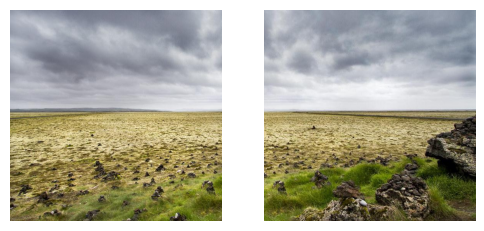

In [166]:
img1 = plt.imread(os.path.join(train_folder, '3_1.jpg'))
img2 = plt.imread(os.path.join(train_folder, '3_2.jpg'))

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

And this is an example of a vertical image that got split:

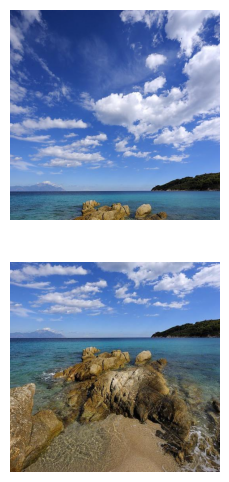

In [167]:
img1 = plt.imread(os.path.join(train_folder, '62_1.jpg'))
img2 = plt.imread(os.path.join(train_folder, '62_2.jpg'))

fig, axes = plt.subplots(2, 1, figsize=(3, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [168]:
print(f"Number of images in train folder: {len(os.listdir(train_folder))}")
print(f"Number of images in validation folder: {len(os.listdir(val_folder))}")
print(f"Number of images in test folder: {len(os.listdir(test_folder))}")

Number of images in train folder: 67
Number of images in validation folder: 20
Number of images in test folder: 22
